In [239]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import model_selection, naive_bayes
from sklearn.metrics import accuracy_score
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud

In [204]:
df = pd.read_csv('7282_1.csv')
df.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [205]:
len(df)

35912

In [206]:
df.columns

Index(['address', 'categories', 'city', 'country', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateAdded',
       'reviews.doRecommend', 'reviews.id', 'reviews.rating', 'reviews.text',
       'reviews.title', 'reviews.userCity', 'reviews.username',
       'reviews.userProvince'],
      dtype='object')

In [207]:
df = df.drop(['reviews.userProvince', 'reviews.userCity', 'reviews.title', 'reviews.doRecommend', 'postalCode', 
         'province', 'reviews.date', 'reviews.dateAdded', 'address', 'reviews.id', 'latitude', 'longitude', 'reviews.username',
             'city', 'name'], axis=1)

In [208]:
df = df[df['categories'] == 'Hotels']

In [209]:
df = df.drop(['categories', 'country'], axis=1)

In [210]:
df.head()

,reviews.rating,reviews.text
0,4.0,Pleasant 10 min walk along the sea front to th...
1,5.0,Really lovely hotel. Stayed on the very top fl...
2,5.0,Ett mycket bra hotell. Det som drog ner betyge...
3,5.0,We stayed here for four nights in October. The...
4,5.0,We stayed here for four nights in October. The...


In [211]:
# remove rows contains null values.
df = df.dropna(how='any',axis=0) 

In [212]:
# convert all floating rating into integer.
df['reviews.rating'] = df["reviews.rating"].apply(lambda x: int(x))

In [213]:
# remove special characters, numbers, punctuations
df['reviews.text'] = df['reviews.text'].str.replace("[^a-zA-Z#]", " ")

In [214]:
# using rating make a label indicates negative revieew if the rating is less than 5 otherwise positive.
df["label"] = df["reviews.rating"].apply(lambda x: 1 if x < 5 else 0)

In [215]:
df.head()

,reviews.rating,reviews.text,label
0,4,Pleasant min walk along the sea front to th...,1
1,5,Really lovely hotel Stayed on the very top fl...,0
2,5,Ett mycket bra hotell Det som drog ner betyge...,0
3,5,We stayed here for four nights in October The...,0
4,5,We stayed here for four nights in October The...,0


In [216]:
df.reset_index(drop=True, inplace=True)

In [217]:
df.head()

,reviews.rating,reviews.text,label
0,4,Pleasant min walk along the sea front to th...,1
1,5,Really lovely hotel Stayed on the very top fl...,0
2,5,Ett mycket bra hotell Det som drog ner betyge...,0
3,5,We stayed here for four nights in October The...,0
4,5,We stayed here for four nights in October The...,0


In [218]:
# remove short words.
df['reviews.text']  = df['reviews.text'] .apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [219]:
# tokenization 
tokenized = df['reviews.text'].apply(lambda x: x.split())

In [220]:
tokenized.head()

0    [Pleasant, walk, along, front, Water, restaura...
1    [Really, lovely, hotel, Stayed, very, floor, w...
2    [mycket, hotell, drog, betyget, fick, under, t...
3    [stayed, here, four, nights, October, hotel, s...
4    [stayed, here, four, nights, October, hotel, s...
Name: reviews.text, dtype: object

In [221]:
#Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. 
#For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.

from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized = tokenized.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized.head()

0    [pleasant, walk, along, front, water, restaur,...
1    [realli, love, hotel, stay, veri, floor, were,...
2    [mycket, hotel, drog, betyget, fick, under, ta...
3    [stay, here, four, night, octob, hotel, staff,...
4    [stay, here, four, night, octob, hotel, staff,...
Name: reviews.text, dtype: object

In [222]:
tokenized

0        [pleasant, walk, along, front, water, restaur,...
1        [realli, love, hotel, stay, veri, floor, were,...
2        [mycket, hotel, drog, betyget, fick, under, ta...
3        [stay, here, four, night, octob, hotel, staff,...
4        [stay, here, four, night, octob, hotel, staff,...
                               ...                        
21349    [great, staff, wonder, boyfriend, becam, that,...
21350    [stay, there, night, attend, game, next, when,...
21351                                        [great, stay]
21352                                     [everyth, great]
21353    [granddaught, graduat, from, colleg, went, yor...
Name: reviews.text, Length: 21354, dtype: object

In [223]:
# now joint this tokens together.
for i in range(len(tokenized)):
    tokenized[i] = ' '.join(tokenized[i])

df['reviews.text'] = tokenized

In [224]:
df.head()

,reviews.rating,reviews.text,label
0,4,pleasant walk along front water restaur hotel ...,1
1,5,realli love hotel stay veri floor were surpris...,0
2,5,mycket hotel drog betyget fick under taksarna ...,0
3,5,stay here four night octob hotel staff were we...,0
4,5,stay here four night octob hotel staff were we...,0


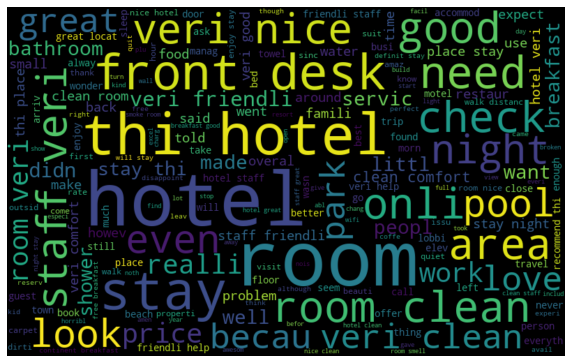

In [225]:
#Understanding the common words used in the review: WordCloud
all_words = ' '.join([text for text in df['reviews.text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

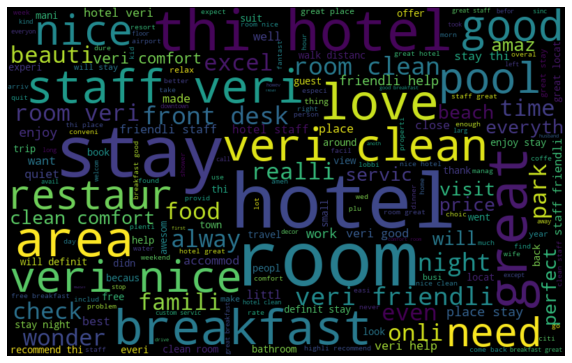

In [226]:
# Words in positive review
normal_words = ' '.join([text for text in df['reviews.text'][df['label']==0]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

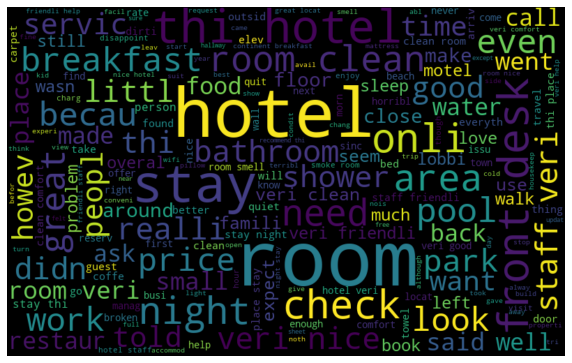

In [227]:
# Words in negative review 
normal_words = ' '.join([text for text in df['reviews.text'][df['label']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [228]:
# now we will test dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(
    df['reviews.text'], 
    df['label'], 
    random_state = 1
)

In [230]:
print("size of training dataset:{0}\nsize of testing dataset:{1}".format(len(X_train),len(X_test)))

size of training dataset:16015
size of testing dataset:5339


In [232]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)

In [235]:
# Building model using TF-IDF features
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['reviews.text'])

In [ ]:
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [240]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  75.95055253792844
